In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm

In [10]:
ticker = 'BTC-USD'
data = pd.DataFrame()
data = wb.DataReader(ticker, data_source = 'yahoo', start = '2007-1-1')

In [11]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2022-04-05,47106.140625,45544.808594,46624.507812,45555.992188,2.964060e+10,45555.992188
2022-04-06,45544.355469,43193.953125,45544.355469,43206.738281,3.939340e+10,43206.738281
2022-04-07,43860.699219,42899.906250,43207.500000,43503.847656,2.610197e+10,43503.847656


In [12]:
# Get the number of rows and columns in the data set
data.shape

(2762, 6)

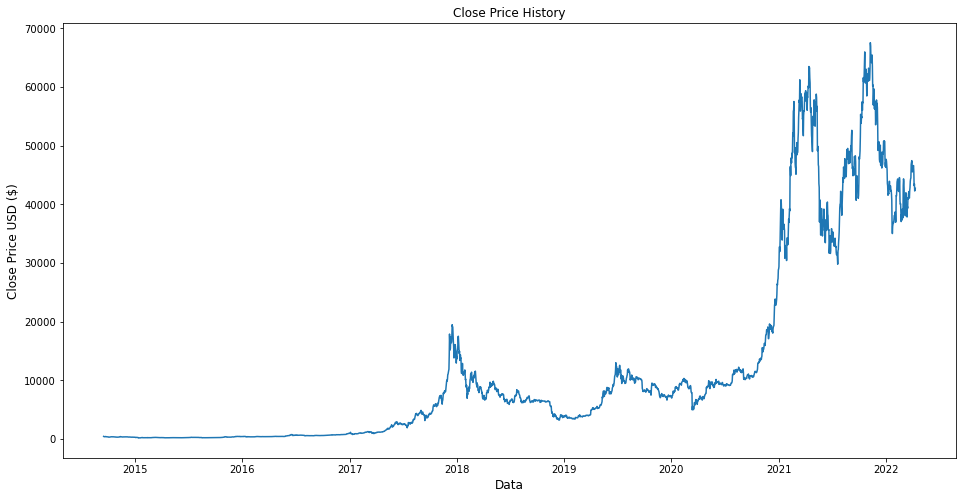

In [24]:
plt.figure(figsize = (16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Data', fontsize = 12)
plt.ylabel('Close Price USD ($)', fontsize = 12)
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
155/155 [==============================] - 4s 12ms/step - loss: 0.0543 - val_loss: 0.0773
Epoch 2/10
155/155 [==============================] - 2s 11ms/step - loss: 0.0255 -

<ipython-input-25-5be9d8dcceb3>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misin

<AxesSubplot:xlabel='Date', ylabel='Close'>

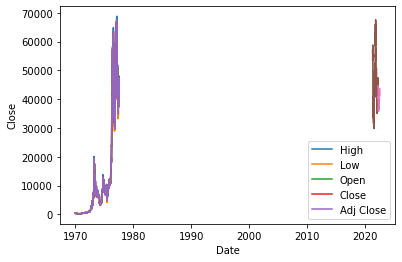

In [25]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import  Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns

ticker = 'BTC-USD'
df = pd.DataFrame()
df = wb.DataReader(ticker, data_source = 'yahoo', start = '2007-1-1')

index_list = list(range(len(df)))

range(len(df))

df = df.reset_index()

train_dates = pd.to_datetime(df['Date'])


""" Variable for training"""
clos = list(df[['High','Low','Open','Close','Adj Close']])

df_for_training = df[clos].astype(float)

df_for_plot = df_for_training.tail(5000)
df_for_plot.plot.line()

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

## The require for LSTM network, we require to reshape an inout data into n_sample x timestep
## in the example, the n_feature is 2, we will make timestep = 3.
## With this, ther resultant n_samples is 5 (as the input data has 9 row)
trainX = []
trainY = []

n_future = 1 #Number of days we want to predict into fufture
n_pass = 14 #Number of past days we want to use to perdict the future

for i in range(n_pass,len(df_for_training_scaled) -n_future +1):
    trainX.append(df_for_training_scaled[i - n_pass: i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1: i + n_future,0])
    
trainX,trainY = np.array(trainX),np.array(trainY)

#print('trainX shape == {}.'.format(trainX.shape))
#print('trainY shape == {}.'.format(trainY.shape))


# define Autoencoder 
model = Sequential()
model.add(LSTM(64,activation='relu', input_shape = (trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


model.compile(optimizer='adam',loss = 'mse')
model.summary()

#fit model
history = model.fit(trainX, trainY, epochs = 10, batch_size = 16, validation_split=0.1, verbose = 1)

#plt.plot(history.history['loss'],lebel = 'Training loss')
#plt.plot(history.history['vol_loss'], lebel = 'Validation loss')
#plt.legend()

n_future = 100

forecast_period_dates = pd.date_range(list(train_dates)[-1], periods = n_future,freq='1d').tolist()

forecast = model.predict(trainX[-n_future:])

forecast_copies = np.repeat(forecast, df_for_training.shape[1],axis=-1)

y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates),'Close':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])



original = df[['Date','Close']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date']> '2021-05-01']



C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Close'>

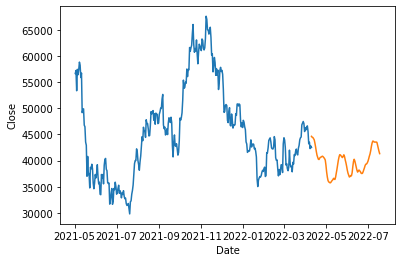

In [26]:
sns.lineplot(original['Date'],original['Close'])
sns.lineplot(df_forecast['Date'],df_forecast['Close'])